In [97]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import hdbscan
from scipy.stats import entropy
from scipy.spatial.distance import pdist, squareform
from scipy.stats import spearmanr
from collections import Counter
from sklearn.linear_model import Ridge, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import r2_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, SpectralClustering
from tqdm import tqdm
from itertools import combinations


palette = sns.color_palette('tab10')
sns.set_palette(palette)
sns.set(context='paper', style='white', font="cmr10", font_scale=1.0)
plt.rcParams['axes.formatter.use_mathtext'] = True

# Load all the spike and value data

In [2]:
def load_nef_values(load=True):
    if load:
        values = pd.read_pickle("data/nef_values_condensed.pkl")
    else:
        emp = pd.read_pickle("data/empirical.pkl")
        dfs = []
        for monkey in ['V', 'W']:
            for session in [0,1,2,3]:
                for block in emp.query("monkey==@monkey & session==@session")['block'].unique():
                    for trial in emp.query("monkey==@monkey & session==@session & block==@block")['trial'].unique():
                        file = f"monkey{monkey}_session{session}_block{block}_trial{trial}"
                        dfs.append(pd.read_pickle(f'data/nef_spikes/{file}_values.pkl'))
        values = pd.concat(dfs, ignore_index=True)
        values['dvs'] = np.abs(values['va'] - values['vb'])
        values['dva'] = np.abs(values['vl'] - values['vr'])
        values['dvt'] = values['dvs'] + values['dva']
        # values.rename(columns={'wab': 'w'}, inplace=True)
        # values = values.dropna()
        values = values.drop(columns='block_type')
        values = values.drop(columns='before')
        values = values.drop(columns='after')
        values.to_pickle("data/nef_values_condensed.pkl")
    return values

In [7]:
def load_rl_values(load=True):
    if load:
        values = pd.read_pickle("data/rl_values_condensed.pkl")
    else:
        dfs = []
        for monkey in ['V', 'W']:
            for session in [0,1,2,3]:
                for block in range(1, 25):
                    for trial in range(1, 81):
                        file = f"monkey{monkey}_session{session}_block{block}_trial{trial}"
                        try:
                            dfs.append(pd.read_pickle(f'data/emp_spikes/{file}_values.pkl'))
                        except:
                            print(block, trial)
                            # pass
        values = pd.concat(dfs, ignore_index=True)
        # values = values.drop(columns='omega_BlockMean')
        # values = values.dropna()
        values.to_pickle("data/rl_values_condensed.pkl")
    return values

In [8]:
def load_nef_spikes(load=True):
    if load:
        with open('data/nef_spikes_condensed.pkl', 'rb') as file:
            nef_spikes = pickle.load(file)
    else:
        nef_spikes = {}
        emp = pd.read_pickle("data/empirical.pkl")
        for monkey in emp['monkey'].unique():
            nef_spikes[monkey] = {}
            for session in emp['session'].unique():
                session = int(session)
                nef_spikes[monkey][session] = {}
                for block in emp.query("monkey==@monkey & session==@session")['block'].unique():
                    block = int(block)
                    nef_spikes[monkey][session][block] = {}
                    for trial in emp.query("monkey==@monkey & session==@session & block==@block")['trial'].unique():
                        trial=int(trial)
                        v = np.load(f"data/nef_spikes/monkey{monkey}_session{session}_block{block}_trial{trial}_spikes.npz")['v'].sum(axis=0)  # sum over time
                        w = np.load(f"data/nef_spikes/monkey{monkey}_session{session}_block{block}_trial{trial}_spikes.npz")['w'].sum(axis=0)  # sum over time
                        a = np.load(f"data/nef_spikes/monkey{monkey}_session{session}_block{block}_trial{trial}_spikes.npz")['a'].sum(axis=0)  # sum over time
                        vwa = np.load(f"data/nef_spikes/monkey{monkey}_session{session}_block{block}_trial{trial}_spikes.npz")['vwa'].sum(axis=0)  # sum over time
                        evc = np.load(f"data/nef_spikes/monkey{monkey}_session{session}_block{block}_trial{trial}_spikes.npz")['evc'].sum(axis=0)  # sum over time
                        ewt = np.load(f"data/nef_spikes/monkey{monkey}_session{session}_block{block}_trial{trial}_spikes.npz")['ewt'].sum(axis=0)  # sum over time
                        # combined = np.concatenate([v,w,a], axis=0)
                        combined = np.concatenate([v,w,a,vwa,evc,ewt], axis=0)
                        nef_spikes[monkey][session][block][trial] = combined
        filename = "nef_spikes_condensed"
        with open(f'data/{filename}.pkl', 'wb') as f:
            pickle.dump(nef_spikes, f)
    return nef_spikes

In [16]:
def load_monkey_spikes(load=True):
    if load:
        with open('data/monkey_spikes_condensed.pkl', 'rb') as file:
            emp_spikes = pickle.load(file)
    else:
        emp_spikes = {}
        emp = pd.read_pickle("data/empirical.pkl")
        for monkey in emp['monkey'].unique():
            emp_spikes[monkey] = {}
            for session in emp['session'].unique():
                session = int(session)
                emp_spikes[monkey][session] = {}
                for block in emp.query("monkey==@monkey & session==@session")['block'].unique():
                    block = int(block)
                    emp_spikes[monkey][session][block] = {}
                    for trial in emp.query("monkey==@monkey & session==@session & block==@block")['trial'].unique():
                        trial=int(trial)
                        try:
                            file = f"data/emp_spikes/monkey{monkey}_session{session}_block{block}_trial{trial}_spikes.npz"
                            emp_spikes[monkey][session][block][trial] = np.load(file)['spikes']
                        except:
                            print(monkey, session, block, trial)
                            # pass
        with open('data/monkey_spikes_condensed.pkl', 'wb') as f:
            pickle.dump(emp_spikes, f)
    return emp_spikes

In [31]:
nef_values = load_nef_values(load=False)
rl_values = load_rl_values(load=False)

10 75
10 76
10 77
10 78
10 79
10 80
12 54
12 55
12 56
12 57
12 58
12 59
12 60
12 61
12 62
12 63
12 64
12 65
12 66
12 67
12 68
12 69
12 70
12 71
12 72
12 73
12 74
12 75
12 76
12 77
12 78
12 79
12 80


In [28]:
nef_spikes = load_nef_spikes(load=False)
monkey_spikes = load_monkey_spikes(load=False)

# Use linear regression to predict values using spikes

In [104]:
def regress_spikes_values(spikes, values, model_type='ridge', preprocess=None, cross_validate=True, alpha=1.0, n_folds=10, n_pca=20):
    dfs_error = []
    dfs_trial = []
    variables = values.columns[4:]
    columns_error = ['monkey', 'session', 'variable', 'r2']
    columns_trial = ['monkey', 'session', 'block', 'trial', 'var', 'true_value', 'pred_value']
    regression_dict = {}
    for monkey in ['V', 'W']:
        regression_dict[monkey] = {}
        for session in [0,1,2,3]:
            print(monkey, session)
            included = []
            regression_dict[monkey][session] = {}
            for variable in variables:
                X = []
                Y = []
                for block in values.query("monkey==@monkey & session==@session")['block'].unique():
                    for trial in values.query("monkey==@monkey & session==@session & block==@block")['trial'].unique():
                        try:
                            x = spikes[monkey][session][block][trial]
                            y = values.query("monkey==@monkey & session==@session & block==@block & trial==@trial")[variable].to_numpy()
                            X.append(x)
                            Y.append(y)
                            included.append([block, trial])
                        except:
                            pass
                X, Y = np.array(X), np.array(Y).ravel()
                if model_type == 'linear':
                    model = LinearRegression()
                elif model_type == 'ridge':
                    model = Ridge(alpha=alpha)
                elif model_type == 'ridgecv':
                    model = RidgeCV(alphas=np.logspace(-3, 1, 10), cv=n_folds, max_iter=10000)
                elif model_type == 'lassocv':
                    model = LassoCV(alphas=np.logspace(-3, 1, 10), cv=n_folds, max_iter=10000)
                elif model_type == 'elasticnetcv':
                    model = ElasticNetCV(l1_ratio=[.1, .5, .9, 1.0], alphas=np.logspace(-3, 1, 10), cv=n_folds)
                if preprocess=='standard':
                    X = StandardScaler().fit_transform(X)
                elif preprocess=='pca':
                    model = make_pipeline(PCA(n_components=n_pca), model)
                if cross_validate:
                    cv = KFold(n_splits=n_folds, shuffle=True, random_state=42)
                    scores = []
                    for train_idx, test_idx in cv.split(X):
                        model.fit(X[train_idx], Y[train_idx])
                        Y_pred = model.predict(X[test_idx])
                        scores.append(r2_score(Y[test_idx], Y_pred))
                    mean_r2 = np.mean(scores)
                    model.fit(X, Y)
                else:
                    model.fit(X, Y)
                    Y_pred = model.predict(X)
                    mean_r2 = r2_score(Y, Y_pred)
                regression_dict[monkey][session][variable] = model
                dfs_error.append(pd.DataFrame([[monkey, session, variable, mean_r2]], columns=columns_error))
                print(variable, mean_r2)
                for i in range(len(X)):
                    x, y = X[i], Y[i]
                    block, trial = included[i][0], included[i][1]
                    y_pred = regression_dict[monkey][session][variable].predict(x.reshape(-1,1).T)[0]
                    dfs_trial.append(pd.DataFrame([[monkey, session, block, trial, variable, y, y_pred]], columns=columns_trial))
    data_error = pd.concat(dfs_error, ignore_index=True)
    data_trial = pd.concat(dfs_trial, ignore_index=True)
    return data_error, data_trial

In [106]:
nef_error, nef_trial = regress_spikes_values(nef_spikes, nef_values, model_type='ridge')
nef_error.to_pickle("data/nef_error.pkl")
nef_trial.to_pickle("data/nef_trial.pkl")
# nef_error = pd.read_pickle("data/nef_error.pkl")
# nef_trial = pd.read_pickle("data/nef_trial.pkl")

V 0
va 0.9821360483646574
vb 0.9854169495391046
vl 0.9832868940138935
vr 0.9773528137839348
wab 0.9889881507930125
wlr 0.9892009786430865
al 0.9861311251072514
ar 0.9858895522991749
evc 0.9956186601965079
ewt 0.9800469244339816
acc -0.5920678682282823
dvs 0.8373267738890119
dva 0.7208285420340111
dvt 0.8101942792121066
V 1
va 0.9895366357270399
vb 0.9902448954824712
vl 0.9929583847667066
vr 0.9902633694385207
wab 0.2907117431190689
wlr 0.2632722291682114
al 0.9923553625980688
ar 0.9919030642096576
evc 0.9942794557501478
ewt 0.9772215628262633
acc -0.5809222147157114
dvs 0.816823107221677
dva 0.7994678332428945
dvt 0.8105104245546872
V 2
va 0.9881342123625705
vb 0.9808194287841256
vl 0.9851870742523058
vr 0.9864836997150086
wab 0.9963212166829887
wlr 0.9962919428714102
al 0.9888993361789149
ar 0.9879709489074775
evc 0.9955388247838982
ewt 0.96485207852527
acc -0.3815882024681037
dvs 0.6966235427217219
dva 0.748678550303234
dvt 0.7583353270179456
V 3
va 0.9673710623986634
vb 0.9828031791

/tmp/ipykernel_1314961/1869509350.py:3: UserWarning: The palette list has more values (10) than needed (9), which may not be intended.
  sns.barplot(nef_error.query("variable==@nef_vars"), x='variable', y='r2', hue='variable', ax=axes, palette=palette)


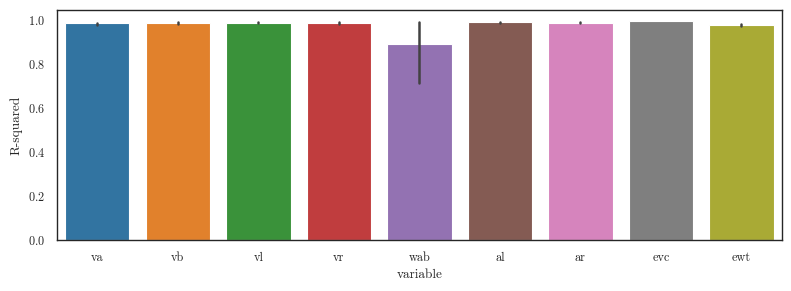

In [107]:
nef_vars = ['va', 'vb', 'vl', 'vr', 'wab', 'al', 'ar', 'evc', 'ewt']
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 3), sharey=True, sharex=True)
sns.barplot(nef_error.query("variable==@nef_vars"), x='variable', y='r2', hue='variable', ax=axes, palette=palette)
fig.tight_layout()
axes.set(ylabel="R-squared")
fig.savefig("plots/nef_spikes_nef_values_regression_ridge.jpg", dpi=600)

## monkey

In [102]:
monkey_error, monkey_trial = regress_spikes_values(monkey_spikes, rl_values, model_type='elasticnetcv')
monkey_error.to_pickle("data/monkey_error.pkl")
monkey_trial.to_pickle("data/monkey_trial.pkl")
# monkey_error = pd.read_pickle("data/monkey_error.pkl")
# monkey_trial = pd.read_pickle("data/monkey_trial.pkl")

V 0
omega 0.5058737638275412
V_Act1 0.45680544891528346
V_Act2 0.4989718919360879
V_StimR 0.5130006984161474
V_StimL 0.5030293729720785
DV_left 0.53743016101536
DV_right 0.5497470290609637
DeltaV_Stim 0.5931062084823931
DeltaV_Act 0.5290162562080031
V 1
omega 0.5999847993352548
V_Act1 0.5819211162966368
V_Act2 0.6082407283106843
V_StimR 0.591331287019327
V_StimL 0.5943369063616272
DV_left 0.6087492101050451
DV_right 0.6198025237403804
DeltaV_Stim 0.6838021704418822
DeltaV_Act 0.6472637927283353
V 2
omega 0.4612117510332334
V_Act1 0.6293328732181449
V_Act2 0.5431774127405059
V_StimR 0.6176221785437375
V_StimL 0.5915725485181352
DV_left 0.6747293194485106
DV_right 0.6058905729208348
DeltaV_Stim 0.6716775320402842
DeltaV_Act 0.6433634119937468
V 3
omega 0.4843571502942008
V_Act1 0.4141231880506167
V_Act2 0.39341049235447223
V_StimR 0.6336282924656998
V_StimL 0.6494919259834281
DV_left 0.6030858023885042
DV_right 0.5864650348948021
DeltaV_Stim 0.7295347225656703
DeltaV_Act 0.43314173199818

/tmp/ipykernel_1314961/3473484811.py:3: UserWarning: The palette list has more values (10) than needed (9), which may not be intended.
  sns.barplot(monkey_error.query("variable==@rl_vars"), x='variable', y='r2', hue='variable', ax=axes, palette=palette)


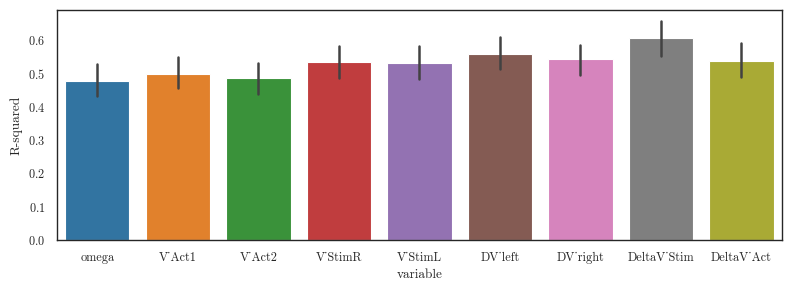

In [103]:
rl_vars = ['V_StimL', 'V_StimR', 'DeltaV_Stim', 'V_Act1', 'V_Act2', 'DeltaV_Act', 'DV_left', 'DV_right', 'omega']
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 3), sharey=True, sharex=True)
sns.barplot(monkey_error.query("variable==@rl_vars"), x='variable', y='r2', hue='variable', ax=axes, palette=palette)
fig.tight_layout()
axes.set(ylabel="R-squared")
fig.savefig("plots/monkey_spikes_rl_values_regression.jpg", dpi=600)

/tmp/ipykernel_1314961/3707622269.py:11: RuntimeWarning: invalid value encountered in divide
  rl_p_stim = rl_dvs / (rl_dvs + rl_dva)
/tmp/ipykernel_1314961/3707622269.py:12: RuntimeWarning: invalid value encountered in divide
  rl_p_act = rl_dva / (rl_dvs + rl_dva)


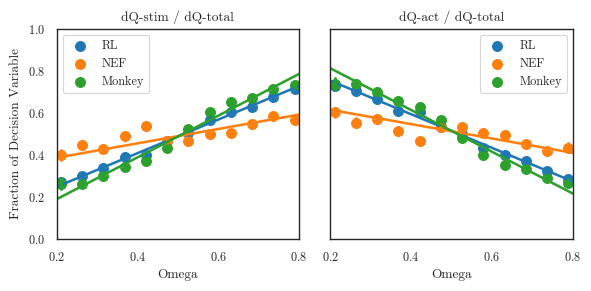

In [24]:
nef_wab = nef_trial.query("var=='wab'")['true_value'].to_numpy()
# nef_wlr = nef_trial.query("var=='wlr'")['true_value'].to_numpy()
nef_dvs = np.abs(nef_trial.query("var=='va'")['true_value'].to_numpy() - nef_trial.query("var=='vb'")['true_value'].to_numpy())
nef_dva = np.abs(nef_trial.query("var=='vl'")['true_value'].to_numpy() - nef_trial.query("var=='vr'")['true_value'].to_numpy())
nef_p_stim = nef_dvs / (nef_dvs + nef_dva)
nef_p_act = nef_dva / (nef_dvs + nef_dva)

rl_w = monkey_trial.query("var=='omega'")['true_value'].to_numpy()
rl_dvs = np.abs(monkey_trial.query("var=='V_StimL'")['true_value'].to_numpy() - monkey_trial.query("var=='V_StimR'")['true_value'].to_numpy())
rl_dva = np.abs(monkey_trial.query("var=='V_Act1'")['true_value'].to_numpy() - monkey_trial.query("var=='V_Act2'")['true_value'].to_numpy())
rl_p_stim = rl_dvs / (rl_dvs + rl_dva)
rl_p_act = rl_dva / (rl_dvs + rl_dva)

monkey_w = monkey_trial.query("var=='omega'")['pred_value'].to_numpy()
monkey_dvs = np.abs(monkey_trial.query("var=='V_StimL'")['pred_value'].to_numpy() - monkey_trial.query("var=='V_StimR'")['pred_value'].to_numpy())
monkey_dva = np.abs(monkey_trial.query("var=='V_Act1'")['pred_value'].to_numpy() - monkey_trial.query("var=='V_Act2'")['pred_value'].to_numpy())
monkey_p_stim = monkey_dvs / (monkey_dvs + monkey_dva)
monkey_p_act = monkey_dva / (monkey_dvs + monkey_dva)

w_bins = np.linspace(0, 1, 20)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6,3), sharex=True, sharey=True)
sns.regplot(x=rl_w, y=rl_p_stim, x_bins=w_bins, ax=axes[0], color=palette[0], label='RL')
sns.regplot(x=nef_wab, y=nef_p_stim, x_bins=w_bins, ax=axes[0], color=palette[1], label='NEF')
sns.regplot(x=monkey_w, y=monkey_p_stim, x_bins=w_bins, ax=axes[0], color=palette[2], label='Monkey')
sns.regplot(x=rl_w, y=rl_p_act, x_bins=w_bins, ax=axes[1], color=palette[0], label='RL')
sns.regplot(x=nef_wab, y=nef_p_act, x_bins=w_bins, ax=axes[1], color=palette[1], label='NEF')
sns.regplot(x=monkey_w, y=monkey_p_act, x_bins=w_bins, ax=axes[1], color=palette[2], label='Monkey')
axes[0].legend()
axes[1].legend()
axes[0].set(ylabel='Fraction of Decision Variable', title="dQ-stim / dQ-total", xlim=(0.2, 0.8), ylim=(0, 1), xlabel='Omega')
axes[1].set(title="dQ-act / dQ-total", xlabel='Omega')
plt.tight_layout()
fig.savefig("plots/fraction_DV_vs_omega.jpg", dpi=600)

# How do spikes relate to represented variables?
Representational Similarity Analysis between intertrial spike changes and intertrial value changes, for different combinations of value variables

In [31]:
def clean_xy(x, y):
    x = np.array(x) # shape: (n_trials, n_neurons)
    y = np.array(y) # shape: (n_trials, n_values)
    if y.shape[1] > 1:
        row_std = np.std(y, axis=1)
        keep = row_std > 1e-6
        x = x[keep, :]  # Remove rows with low variance
        y = y[keep, :]  # Remove rows with low variance
    return x, y

def flatten_rdm(rdm):
    return rdm[np.triu_indices_from(rdm, k=1)]

def RSA(monkey, session, spikes, values, variables, metric='correlation'):
    X_spikes = []
    Y_values = []
    for block in values.query("monkey==@monkey & session==@session")['block'].unique():
        for trial in values.query("monkey==@monkey & session==@session & block==@block")['trial'].unique():
            # try:
            x = spikes[monkey][session][block][trial]
            y = values.query("monkey==@monkey & session==@session & block==@block & trial==@trial")[variables].values.flatten()
            X_spikes.append(x.astype(float))
            Y_values.append(y.astype(float))
            # except:
            #     print(f"skipping {monkey} {session} {block} {trial}")
    X_spikes, Y_values = clean_xy(X_spikes, Y_values)
    X_rdm = squareform(pdist(X_spikes, metric=metric))  # shape: (n_trials, n_trials)
    Y_rdm = squareform(pdist(Y_values, metric=metric))  # shape: (n_trials, n_trials)
    X_vec = flatten_rdm(X_rdm)
    Y_vec = flatten_rdm(Y_rdm)
    rsa_score, pval = spearmanr(X_vec, Y_vec)  # Spearman correlation
    # print(f"monkey {monkey}, session {session}, Overall RSA Spearman r = {rsa_score:.3f}, p = {pval:.3e}")
    return rsa_score, pval

def RSA_vs_variables(spikes, values, variables_list):
    dfs = []
    columns = ['monkey', 'session', 'variables', 'score', 'p']
    for monkey in ['V', 'W']:
        for session in [0,1,2,3]:
            print(monkey, session)
            for variables in variables_list:
                score, p = RSA(monkey, session, spikes, values, variables)
                dfs.append(pd.DataFrame([[monkey, session, variables, score, p]], columns=columns))
    data = pd.concat(dfs, ignore_index=True)
    return data

def RSA_by_spikes(nef_spikes, monkey_spikes, variables_list):
    dfs = []
    columns = ['monkey', 'session', 'score', 'p']
    for monkey in ['V', 'W']:
        for session in [0,1,2,3]:
            print(monkey, session)
            S1 = []
            S2 = []
            for block in values.query("monkey==@monkey & session==@session")['block'].unique():
                for trial in values.query("monkey==@monkey & session==@session & block==@block")['trial'].unique():
                    S1.append(nef_spikes[monkey][session][block][trial])
                    S2.append(monkey_spikes[monkey][session][block][trial])
            S1, S2 = np.array(S1), np.array(S2)
            S1_rdm = squareform(pdist(S1, metric=metric))  # shape: (n_trials, n_trials)
            S2_rdm = squareform(pdist(S2, metric=metric))  # shape: (n_trials, n_trials)
            S1_vec = flatten_rdm(X_rdm)
            S2_vec = flatten_rdm(Y_rdm)
            score, p = spearmanr(S1_vec, S2_vec)  # Spearman correlation
            dfs.append(pd.DataFrame([[monkey, session, score, p]], columns=columns))
    data = pd.concat(dfs, ignore_index=True)
    return data

In [29]:
rl_vars = ['V_StimL', 'V_StimR', 'DeltaV_Stim', 'V_Act1', 'V_Act2', 'DeltaV_Act', 'DV_left', 'DV_right', 'omega']
a = ['V_StimL', 'V_StimR']
b = ['V_Act1', 'V_Act2']
c = ['V_Act1', 'V_Act2']
d = ['DeltaV_Act', 'DeltaV_Stim']
e = ['DV_left', 'DV_right', 'omega']
f = ['DeltaV_Act', 'DeltaV_Stim', 'omega']
g = ['V_StimL', 'V_StimR', 'V_Act1', 'V_Act2']
variables_list = [a,b,c,d,e,f,g]
monkey_rsa = RSA_vs_variables(monkey_spikes, rl_values, variables_list)

V 0
V 1
V 2
V 3
W 0
W 1
W 2
W 3


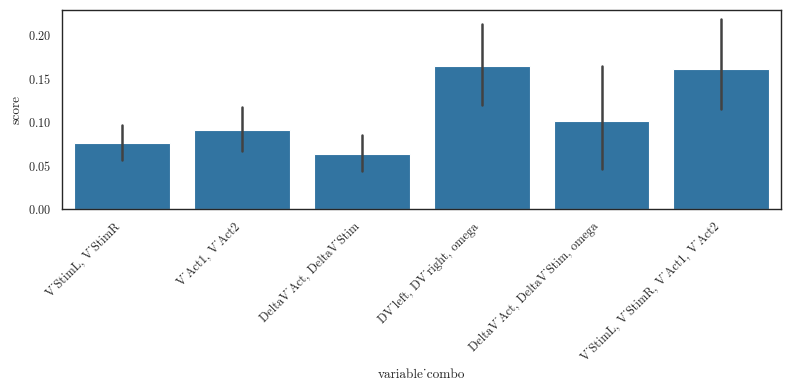

In [189]:
monkey_rsa['variable_combo'] = monkey_rsa['variables'].apply(lambda x: ', '.join(x))
fig, ax = plt.subplots(figsize=(8,4))
sns.barplot(monkey_rsa, x='variable_combo', y='score', ax=ax, color=palette[0])
plt.xticks(rotation=45, ha='right')
fig.tight_layout()
plt.show()

In [34]:
a = ['al', 'ar']
b = ['dvs', 'dva']
c = ['al', 'ar', 'wab']
d = ['evc', 'ewt']
e = ['va', 'vb', 'vl', 'vr']
f = ['va', 'vb', 'vl', 'vr', 'wab']
g = ['va', 'vb', 'vl', 'vr', 'wab', 'al', 'ar']
h = ['va', 'vb', 'vl', 'vr', 'wab', 'al', 'ar', 'evc', 'ewt']
variables_list = [a,b,c,d,e,f,g,h]
nef_rsa = RSA_vs_variables(nef_spikes, nef_values, variables_list)

V 0
V 1


KeyboardInterrupt: 

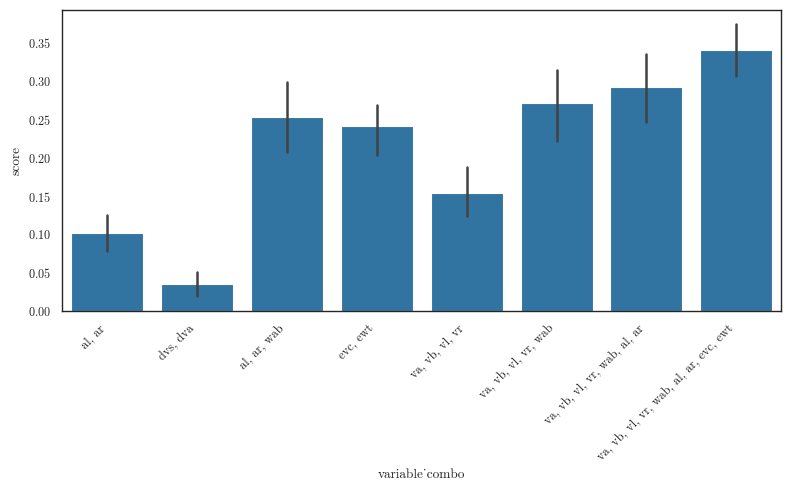

In [169]:
nef_rsa['variable_combo'] = nef_rsa['variables'].apply(lambda x: ', '.join(x))
fig, ax = plt.subplots(figsize=(8,5))
sns.barplot(nef_rsa, x='variable_combo', y='score', ax=ax, color=palette[0])
plt.xticks(rotation=45, ha='right')
fig.tight_layout()
plt.show()

# Neuron selectivity

In [61]:
def spike_entropy(spikes, values, spike_type, value_type, epsilon=1e-10, normalization='neuron'):
    dfs = []
    if value_type=='rl':
        # variables = ['va', 'vb', 'vl', 'vr', 'w', 'al', 'ar', 'dvc', 'dvs', 'dva']
        variables = ['w', 'al', 'ar', 'dvs', 'dva']
        # variables = ['va', 'vb', 'vl', 'vr', 'w', 'al', 'ar']
    elif value_type=='nef':
        variables = ['va', 'vb', 'vl', 'vr', 'wab', 'wlr', 'al', 'ar']  #  'evc', 'ewt'
    columns = ['monkey', 'session', 'neuron', 'population', 'variable', 'weight', 'norm_weight', 'entropy']
    for monkey in ['V', 'W']:
        for session in [0,1,2,3]:
            print(monkey, session)
            X = []
            Y = []
            for block in values.query("monkey==@monkey & session==@session")['block'].unique():
                for trial in values.query("monkey==@monkey & session==@session & block==@block")['trial'].unique():
                    try:
                        X.append(spikes[monkey][session][block][trial])
                        y = []
                        for variable in variables:
                                yi = values.query("monkey==@monkey & session==@session & block==@block & trial==@trial")[variable].to_numpy()[0]
                                y.append(yi)
                        Y.append(y)
                    except:
                        pass
            X, Y = clean_paired_array_lists(X, Y)
            n_neurons = X.shape[1]
            pipeline = make_pipeline(StandardScaler(), Ridge(alpha=1.0))
            pipeline.fit(X, Y)
            ridge = pipeline.named_steps['ridge']  # Extract weights (neurons × variables)
            sqr_weights = np.square(ridge.coef_.T)  # N × k (neurons × value variables)
            if normalization=='global':
                norm_weights = sqr_weights / (np.sum(sqr_weights) + epsilon) # Compute normalized squared weights
            elif normalization=='neuron':
                norm_weights = sqr_weights / (sqr_weights.sum(axis=1, keepdims=True) + epsilon) # Compute normalized squared weights
            entropies = entropy(norm_weights.T + epsilon)  # Entropy per neuron; shape: (neurons,)
            for v, variable in enumerate(variables):
                # print(v, variable)
                df = pd.DataFrame(columns=columns)
                df['monkey'] = [monkey for _ in range(n_neurons)]
                df['session'] = [session for _ in range(n_neurons)]
                df['neuron'] = [n for n in range(n_neurons)]
                if spike_type=='nef':
                    pops = []
                    for pop in ['v', 'w', 'a']:
                        pops.extend([pop for _ in range(int(n_neurons/3))])
                    df['population'] = pops
                else:
                    df['population'] = ['all' for n in range(n_neurons)]
                df['variable'] = [variable for _ in range(n_neurons)]
                df['entropy'] = entropies
                df['weight'] = sqr_weights[:,v]
                df['norm_weight'] = norm_weights[:,v]
                dfs.append(df)
    neuron_weights = pd.concat(dfs, ignore_index=True)
    neuron_weights.to_pickle("data/nef_spikes/neuron_weights.pkl")
    return neuron_weights

## NEF

In [46]:
nef_weights = spike_entropy(nef_spikes, nef_values, 'nef', 'nef', normalization='neuron')

V 0
V 1
V 2
V 3
W 0
W 1
W 2
W 3


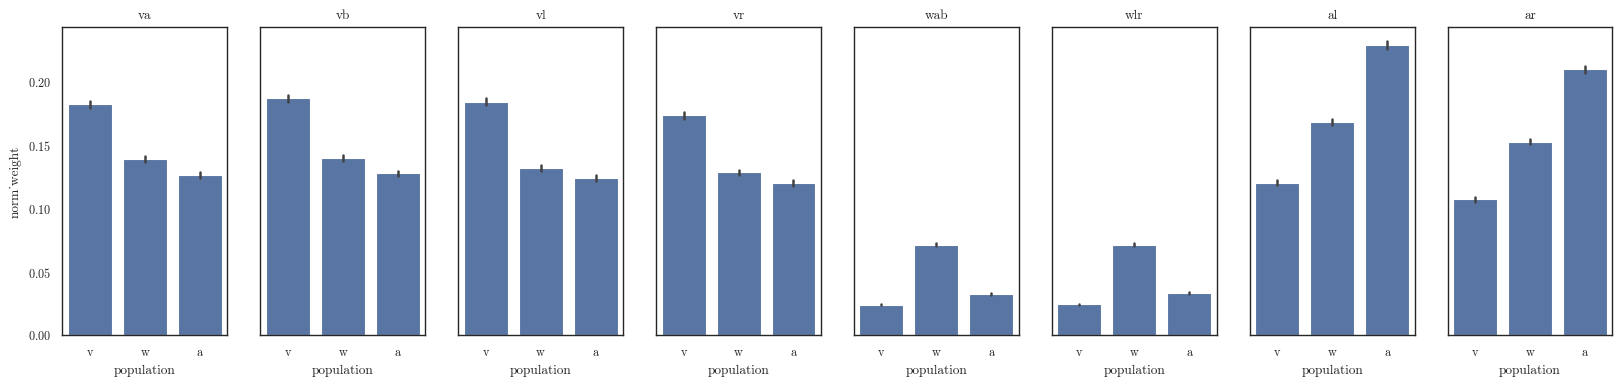

In [17]:
variables = neuron_weights['variable'].unique()
fig, axes = plt.subplots(nrows=1, ncols=len(variables), figsize=(20, 4), sharey=True)
for v, variable in enumerate(variables):
    # sns.barplot(neuron_weights.query("variable==@variable"), x='population', y='weight', ax=axes[v])
    sns.barplot(neuron_weights.query("variable==@variable"), x='population', y='norm_weight', ax=axes[v])
    axes[v].set(title=variable)
plt.show()

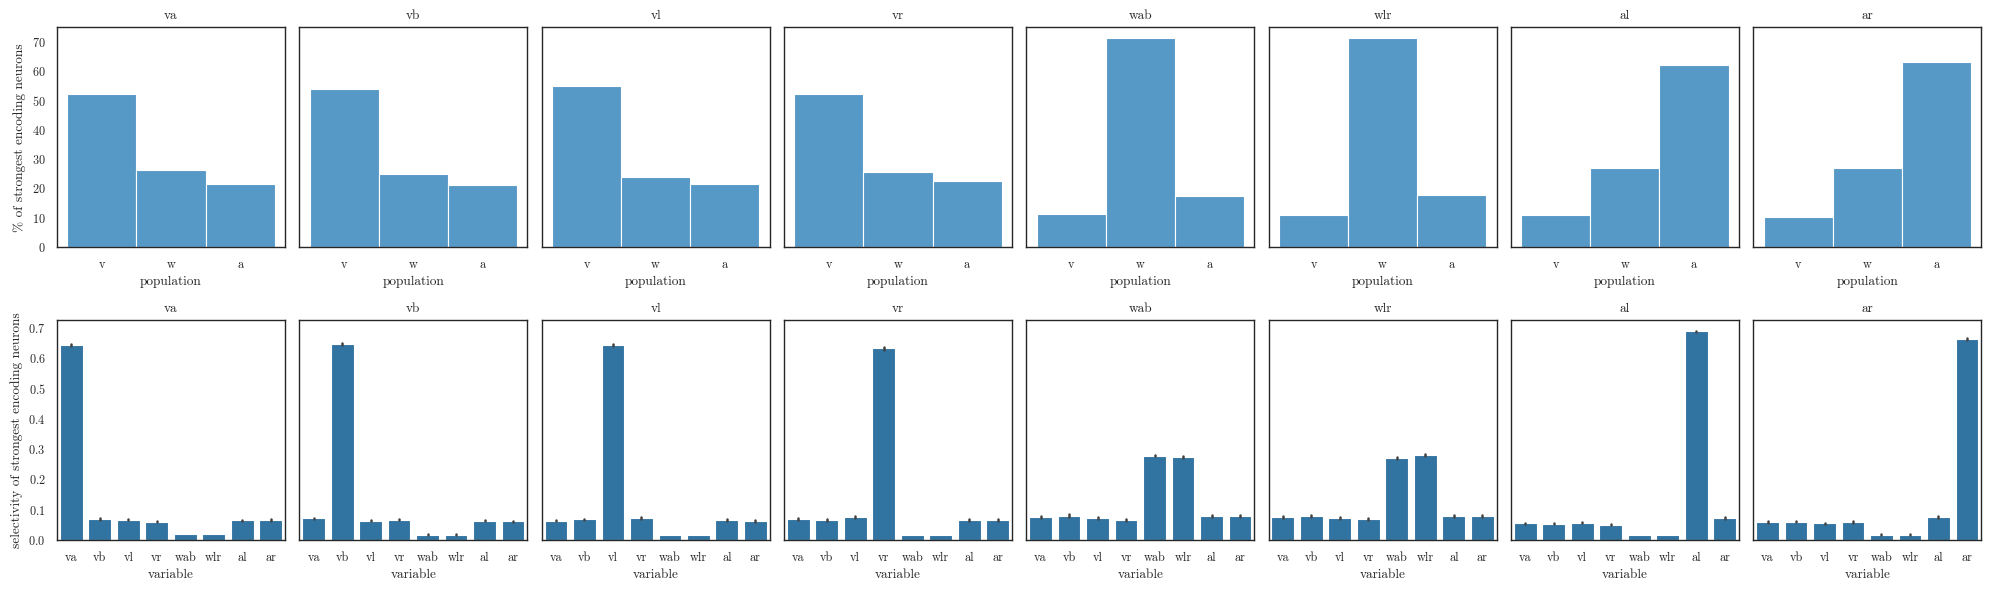

In [72]:
percentile = 95
variables = neuron_weights['variable'].unique()
fig, axes = plt.subplots(nrows=2, ncols=len(variables), figsize=(20, 6), sharey='row')
for v, variable in enumerate(variables):
    nw = neuron_weights.query("variable==@variable")
    thr = np.percentile(nw['norm_weight'].to_numpy(), percentile)
    top = nw.query("norm_weight>=@thr")
    sns.histplot(top, x='population', ax=axes[0][v], stat='percent', color=palette[0])
    # look at the neurons in top, and plot their norm_weights for all variables
    top_monkeys = top['monkey'].to_numpy()
    top_sessions = top['session'].to_numpy()
    top_neurons = top['neuron'].to_numpy()
    key_df = pd.DataFrame({'monkey': top_monkeys, 'session': top_sessions, 'neuron': top_neurons})
    filtered_df = neuron_weights.merge(key_df, on=['monkey', 'session', 'neuron'], how='inner')
    sns.barplot(filtered_df, x='variable', y='norm_weight', ax=axes[1][v], color=palette[0])
    axes[0][v].set(title=variable, ylabel=f'% of strongest encoding neurons')
    axes[1][v].set(title=variable, ylabel=f'selectivity of strongest encoding neurons')
plt.tight_layout()
plt.show()

## Monkey

In [62]:
monkey_weights = spike_entropy(monkey_spikes, rl_values, 'monkey', 'rl', normalization='neuron')

V 0
V 1
V 2
V 3
W 0
W 1
W 2
W 3


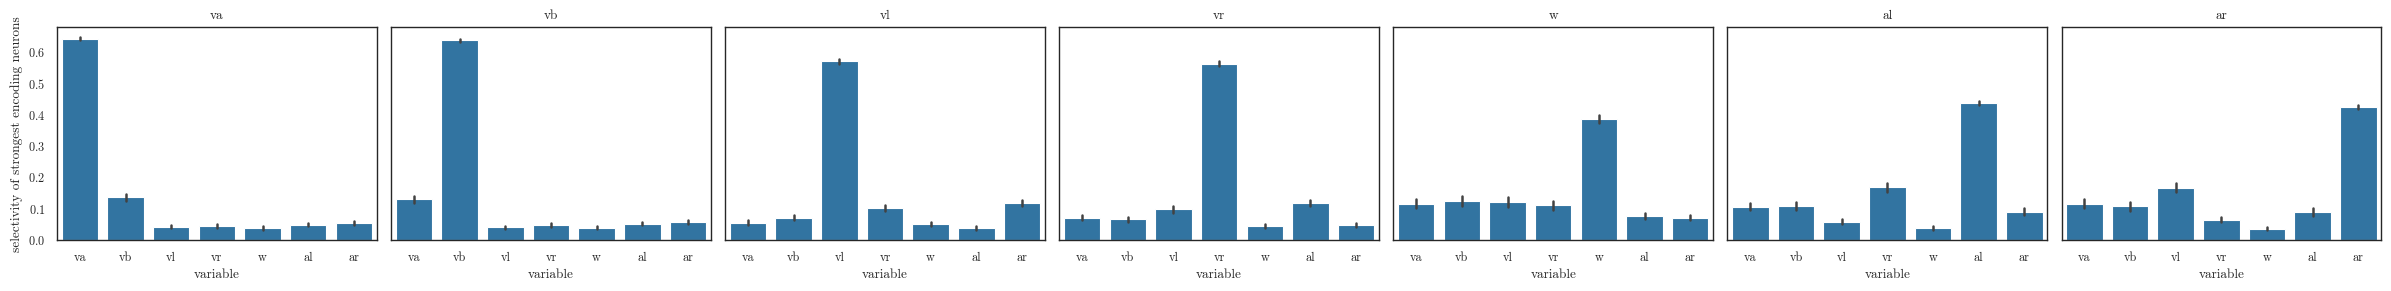

In [59]:
percentile = 95
variables = monkey_weights['variable'].unique()
fig, axes = plt.subplots(nrows=1, ncols=len(variables), figsize=(24, 3), sharey='row')
for v, variable in enumerate(variables):
    nw = monkey_weights.query("variable==@variable")
    thr = np.percentile(nw['norm_weight'].to_numpy(), percentile)
    top = nw.query("norm_weight>=@thr")
    # look at the neurons in top, and plot their norm_weights for all variables
    top_monkeys = top['monkey'].to_numpy()
    top_sessions = top['session'].to_numpy()
    top_neurons = top['neuron'].to_numpy()
    key_df = pd.DataFrame({'monkey': top_monkeys, 'session': top_sessions, 'neuron': top_neurons})
    filtered_df = monkey_weights.merge(key_df, on=['monkey', 'session', 'neuron'], how='inner')
    sns.barplot(filtered_df, x='variable', y='norm_weight', ax=axes[v], color=palette[0])
    axes[v].set(title=variable, ylabel=f'selectivity of strongest encoding neurons')
plt.tight_layout()
plt.show()

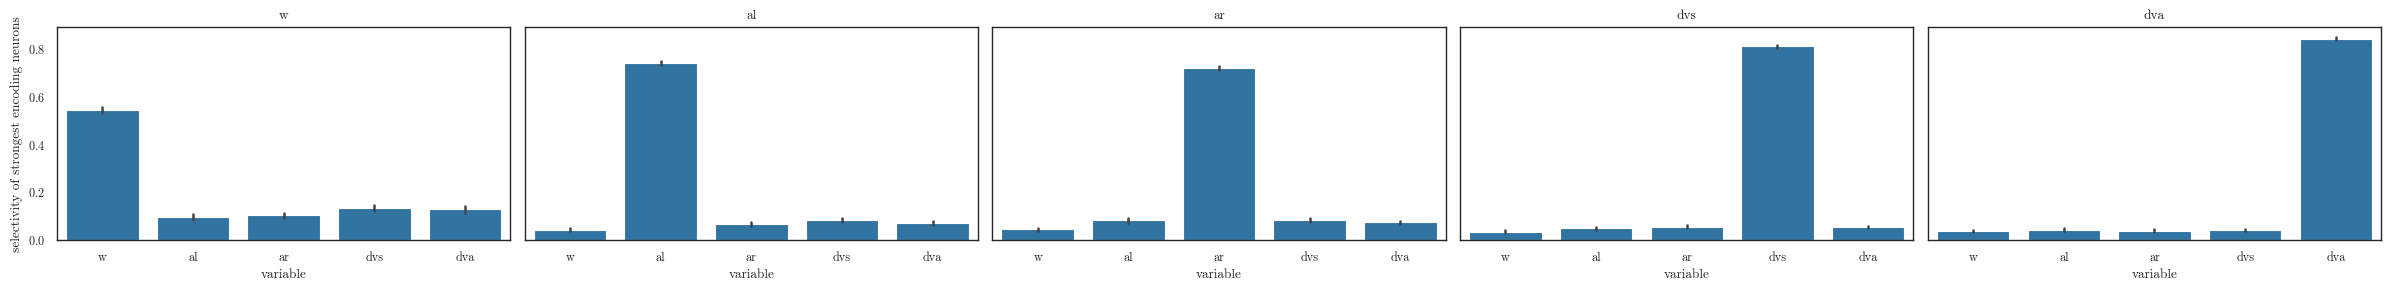

In [63]:
percentile = 95
variables = monkey_weights['variable'].unique()
fig, axes = plt.subplots(nrows=1, ncols=len(variables), figsize=(24, 3), sharey='row')
for v, variable in enumerate(variables):
    nw = monkey_weights.query("variable==@variable")
    thr = np.percentile(nw['norm_weight'].to_numpy(), percentile)
    top = nw.query("norm_weight>=@thr")
    # look at the neurons in top, and plot their norm_weights for all variables
    top_monkeys = top['monkey'].to_numpy()
    top_sessions = top['session'].to_numpy()
    top_neurons = top['neuron'].to_numpy()
    key_df = pd.DataFrame({'monkey': top_monkeys, 'session': top_sessions, 'neuron': top_neurons})
    filtered_df = monkey_weights.merge(key_df, on=['monkey', 'session', 'neuron'], how='inner')
    sns.barplot(filtered_df, x='variable', y='norm_weight', ax=axes[v], color=palette[0])
    axes[v].set(title=variable, ylabel=f'selectivity of strongest encoding neurons')
plt.tight_layout()
plt.show()

# RSA

In [170]:
# Flatten upper triangle to compute similarity
def flatten_rdm(rdm):
    return rdm[np.triu_indices_from(rdm, k=1)]

In [171]:
def clean_trial_data(X_list, Y_list):
    """
    Filters trial-wise data from two lists:
    - X_list: list of (n_neurons,) arrays
    - Y_list: list of (n_variables,) arrays

    Returns:
        X_all: (n_good_trials, n_neurons)
        Y_all: (n_good_trials, n_variables)
    """
    assert len(X_list) == len(Y_list), "X and Y must have the same number of trials"

    X_clean = []
    Y_clean = []
    expected_n_neurons = None
    expected_n_vars = None

    for X, Y in zip(X_list, Y_list):
        # Check both are arrays
        if not isinstance(X, np.ndarray) or not isinstance(Y, np.ndarray):
            continue

        # Check they are 1D
        if X.ndim != 1 or Y.ndim != 1:
            continue

        # Set expected dimensions
        if expected_n_neurons is None:
            expected_n_neurons = X.shape[0]
            expected_n_vars = Y.shape[0]

        # Check correct dimensions
        if X.shape[0] != expected_n_neurons or Y.shape[0] != expected_n_vars:
            continue

        # Check for NaNs or Infs
        if np.any(np.isnan(X)) or np.any(np.isnan(Y)):
            continue
        if np.any(np.isinf(X)) or np.any(np.isinf(Y)):
            continue

        X_clean.append(X)
        Y_clean.append(Y)

    if not X_clean:
        raise ValueError("No valid trials found after filtering.")

    X_all = np.stack(X_clean)
    Y_all = np.stack(Y_clean)

    print(f"Kept {len(X_clean)} of {len(X_list)} trials")

    return X_all, Y_all


In [ ]:
for monkey in ['V', 'W']:
    for session in [0,1,2,3]:
        X_neural = []
        # for block in nef_spikes[monkey][session].keys():
        #     for trial in nef_spikes[monkey][session][block].keys():
        for block in nef_values.query("monkey==@monkey & session==@session")['block'].unique():
            for trial in nef_values.query("monkey==@monkey & session==@session & block==@block")['trial'].unique():
                X_neural.append(nef_spikes[monkey][session][block][trial])
        X_neural = np.array(X_neural) # shape: (n_trials, n_neurons)
        Y_values = nef_values.query("monkey==@monkey & session==@session").to_numpy()[:,7:15]  # shape: (n_trials, n_values)
        neural_rdm = squareform(pdist(X_neural, metric='correlation'))  # shape: (n_trials, n_trials)
        model_rdm_combined = squareform(pdist(Y_values, metric='correlation'))  # shape: (n_trials, n_trials)
        neural_vec = flatten_rdm(neural_rdm)
        model_vec_combined = flatten_rdm(model_rdm_combined)
        rsa_score, pval = spearmanr(neural_vec, model_vec_combined)  # Spearman correlation
        print(f"monkey {monkey}, session {session}, Overall RSA Spearman r = {rsa_score:.3f}, p = {pval:.3e}")

In [42]:
for monkey in ['V', 'W']:
    for session in [0,1,2,3]:
        X_neural = []
        Y_values = []
        for block in rl_values.query("monkey==@monkey & session==@session")['block'].unique():
            for trial in rl_values.query("monkey==@monkey & session==@session & block==@block")['trial'].unique():
        # for block in monkey_spikes[monkey][session].keys():
        #     for trial in monkey_spikes[monkey][session][block].keys():
                try:
                    x = monkey_spikes[monkey][session][block][trial]
                    y = rl_values.query("monkey==@monkey & session==@session & block==@block & trial==@trial").to_numpy()[:,8:11].flatten()
                    # y = nef_values.query("monkey==@monkey & session==@session & block==@block & trial==@trial").to_numpy()[:,7:15].flatten()
                    X_neural.append(x.astype(float))
                    Y_values.append(y.astype(float))
                except:
                    print(f"skipping {monkey} {session} {block} {trial}")
        # X_neural, Y_values = clean_trial_data(X_neural, Y_values)
        X_neural = np.array(X_neural) # shape: (n_trials, n_neurons)
        Y_values = np.array(Y_values) # shape: (n_trials, n_values)
        row_std = np.std(Y_values, axis=1)
        keep = row_std > 1e-6
        X_clean = X_neural[keep, :]  # Remove rows with low variance
        Y_clean = Y_values[keep, :]  # Remove rows with low variance
        # print(X_neural.sum(), Y_values.sum())
        # print(X_clean.sum(), Y_clean.sum())
        neural_rdm = squareform(pdist(X_clean, metric='correlation'))  # shape: (n_trials, n_trials)
        # Y_values = rl_values.query("monkey==@monkey & session==@session").to_numpy()[:,4:11]  # shape: (n_trials, n_values)
        # Y_values = nef_values.query("monkey==@monkey & session==@session").to_numpy()[:,7:15]  # shape: (n_trials, n_values)
        model_rdm_combined = squareform(pdist(Y_clean, metric='correlation'))  # shape: (n_trials, n_trials)
        neural_vec = flatten_rdm(neural_rdm)
        model_vec_combined = flatten_rdm(model_rdm_combined)
        # print(neural_rdm)
        # print(model_rdm_combined)
        rsa_score, pval = spearmanr(neural_vec, model_vec_combined)  # Spearman correlation
        print(f"monkey {monkey}, session {session}, Overall RSA Spearman r = {rsa_score:.3f}, p = {pval:.3e}")

monkey V, session 0, Overall RSA Spearman r = 0.123, p = 0.000e+00
monkey V, session 1, Overall RSA Spearman r = 0.259, p = 0.000e+00
monkey V, session 2, Overall RSA Spearman r = 0.218, p = 0.000e+00
monkey V, session 3, Overall RSA Spearman r = 0.274, p = 0.000e+00
monkey W, session 0, Overall RSA Spearman r = 0.217, p = 0.000e+00
monkey W, session 1, Overall RSA Spearman r = 0.209, p = 0.000e+00
monkey W, session 2, Overall RSA Spearman r = 0.099, p = 0.000e+00
monkey W, session 3, Overall RSA Spearman r = 0.087, p = 0.000e+00


# Clustering based on regression weights

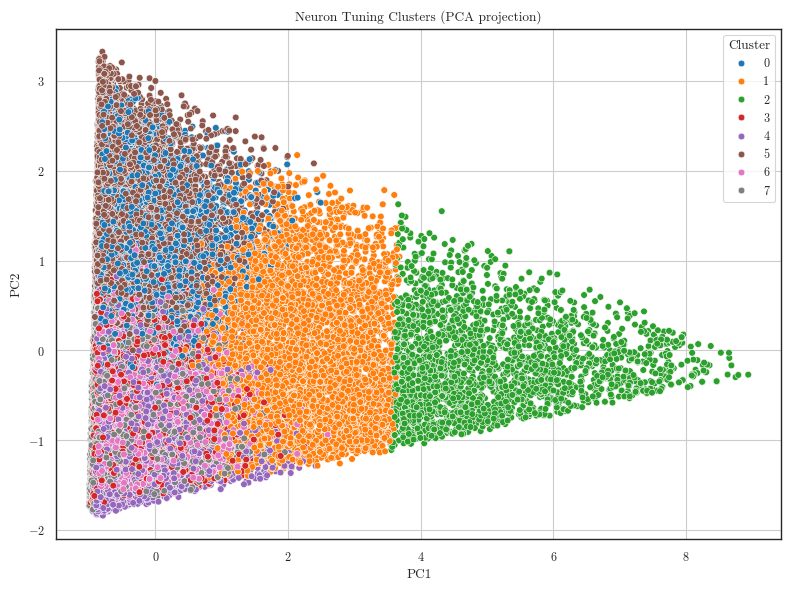

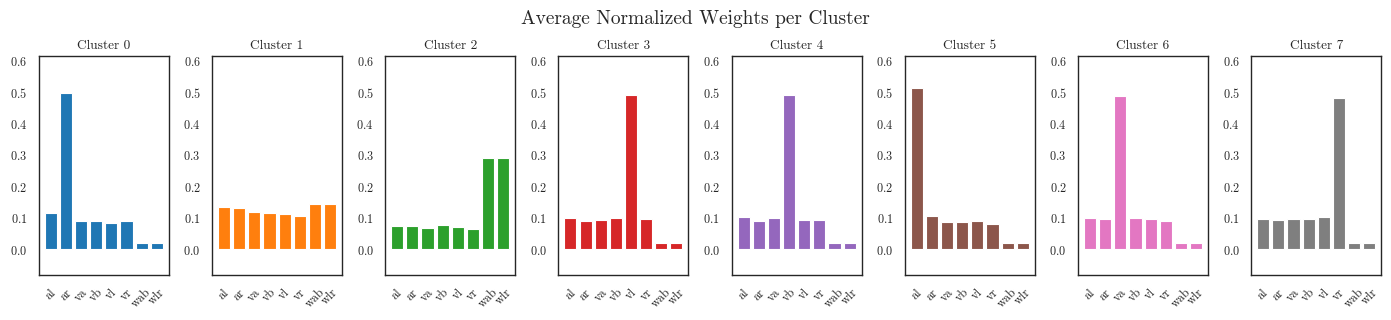

In [55]:
# --- Step 1: Build tuning matrix ---
tuning_df = neuron_weights.pivot_table(
    index=['monkey', 'session', 'neuron', 'population'],
    columns='variable',
    values='norm_weight',
    aggfunc='first'
).dropna()

tuning_matrix = tuning_df.to_numpy()
tuning_matrix_scaled = StandardScaler().fit_transform(tuning_matrix)

# --- Step 2: Automatically determine best number of clusters ---
# sil_scores = []
# k_range = range(2, 11)  # Try K from 2 to 10

# for k in k_range:
#     kmeans_k = KMeans(n_clusters=k, random_state=0, n_init='auto')
#     labels_k = kmeans_k.fit_predict(tuning_matrix_scaled)
#     score = silhouette_score(tuning_matrix_scaled, labels_k)
#     sil_scores.append(score)

# best_k = k_range[np.argmax(sil_scores)]
# print(f"Best number of clusters (by silhouette): {best_k}")

best_k = 8

# --- Step 3: Final clustering with best K ---
kmeans = KMeans(n_clusters=best_k, random_state=0, n_init='auto')
cluster_labels = kmeans.fit_predict(tuning_matrix_scaled)
tuning_df['cluster'] = cluster_labels

# --- Step 4: Dominant variable per neuron ---
# Dominant = variable with largest absolute norm_weight
abs_weights = np.abs(tuning_df.drop(columns='cluster'))
dominant_var = abs_weights.idxmax(axis=1)
tuning_df['dominant_variable'] = dominant_var

# --- Step 5: Visualize tuning space with PCA ---
pca = PCA(n_components=2)
proj_2d = pca.fit_transform(tuning_matrix_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=proj_2d[:, 0], y=proj_2d[:, 1],
                hue=tuning_df['cluster'], palette='tab10')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Neuron Tuning Clusters (PCA projection)')
plt.legend(title='Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Step 6: Visualize mean tuning vector per cluster ---
cluster_means = tuning_df.drop(columns=['cluster', 'dominant_variable']).groupby(tuning_df['cluster']).mean()

# Plot cluster-wise tuning profiles
n_clusters = cluster_means.shape[0]
variables = cluster_means.columns

plt.figure(figsize=(14, 3))
for i in range(n_clusters):
    plt.subplot(1, n_clusters, i + 1)
    plt.bar(variables, cluster_means.iloc[i], color=sns.color_palette('tab10')[i])
    plt.xticks(rotation=45)
    plt.title(f'Cluster {i}')
    plt.ylim(cluster_means.min().min() - 0.1, cluster_means.max().max() + 0.1)
    plt.tight_layout()

plt.suptitle("Average Normalized Weights per Cluster", fontsize=14, y=1.05)
plt.show()


Best number of clusters (by silhouette): 7


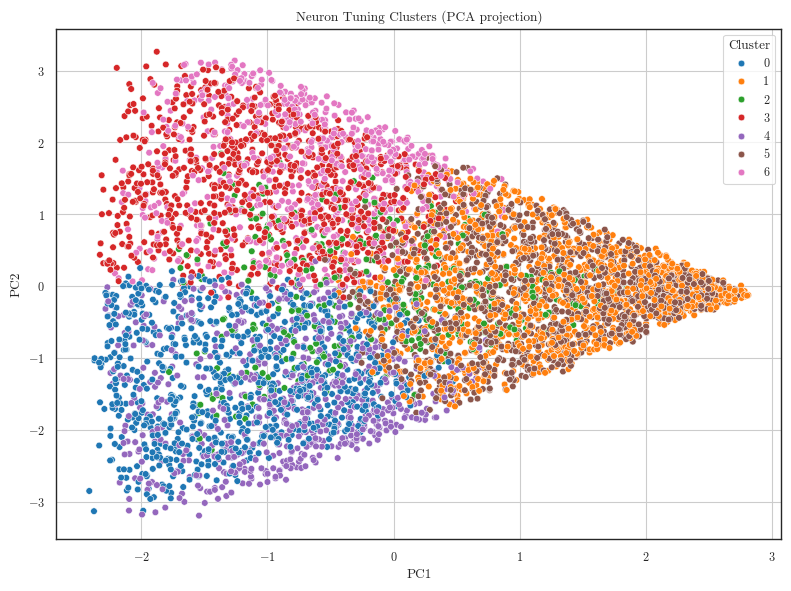

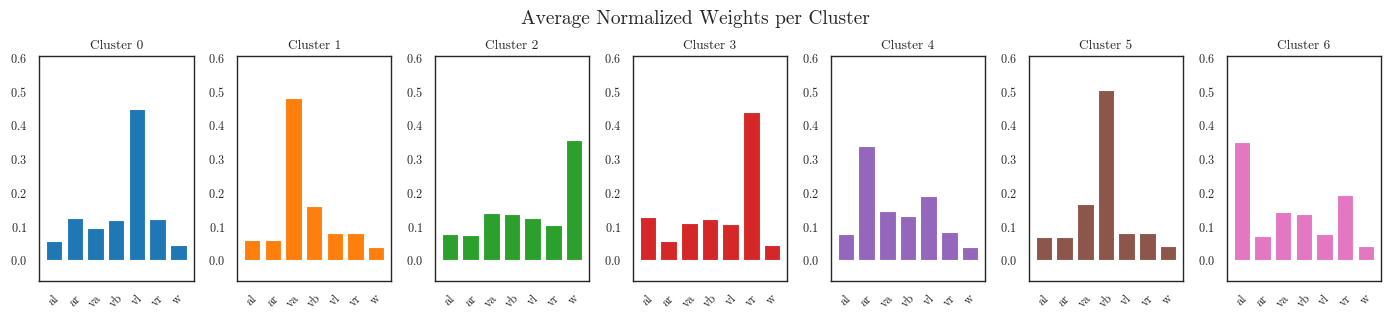

In [60]:
# --- Step 1: Build tuning matrix ---
tuning_df = monkey_weights.pivot_table(
    index=['monkey', 'session', 'neuron', 'population'],
    columns='variable',
    values='norm_weight',
    aggfunc='first'
).dropna()

tuning_matrix = tuning_df.to_numpy()
tuning_matrix_scaled = StandardScaler().fit_transform(tuning_matrix)

# --- Step 2: Automatically determine best number of clusters ---
sil_scores = []
k_range = range(2, 11)  # Try K from 2 to 10

for k in k_range:
    kmeans_k = KMeans(n_clusters=k, random_state=0, n_init='auto')
    labels_k = kmeans_k.fit_predict(tuning_matrix_scaled)
    score = silhouette_score(tuning_matrix_scaled, labels_k)
    sil_scores.append(score)

best_k = k_range[np.argmax(sil_scores)]
print(f"Best number of clusters (by silhouette): {best_k}")

# best_k = 8

# --- Step 3: Final clustering with best K ---
kmeans = KMeans(n_clusters=best_k, random_state=0, n_init='auto')
cluster_labels = kmeans.fit_predict(tuning_matrix_scaled)
tuning_df['cluster'] = cluster_labels

# --- Step 4: Dominant variable per neuron ---
# Dominant = variable with largest absolute norm_weight
abs_weights = np.abs(tuning_df.drop(columns='cluster'))
dominant_var = abs_weights.idxmax(axis=1)
tuning_df['dominant_variable'] = dominant_var

# --- Step 5: Visualize tuning space with PCA ---
pca = PCA(n_components=2)
proj_2d = pca.fit_transform(tuning_matrix_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=proj_2d[:, 0], y=proj_2d[:, 1],
                hue=tuning_df['cluster'], palette='tab10')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Neuron Tuning Clusters (PCA projection)')
plt.legend(title='Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Step 6: Visualize mean tuning vector per cluster ---
cluster_means = tuning_df.drop(columns=['cluster', 'dominant_variable']).groupby(tuning_df['cluster']).mean()

# Plot cluster-wise tuning profiles
n_clusters = cluster_means.shape[0]
variables = cluster_means.columns

plt.figure(figsize=(14, 3))
for i in range(n_clusters):
    plt.subplot(1, n_clusters, i + 1)
    plt.bar(variables, cluster_means.iloc[i], color=sns.color_palette('tab10')[i])
    plt.xticks(rotation=45)
    plt.title(f'Cluster {i}')
    plt.ylim(cluster_means.min().min() - 0.1, cluster_means.max().max() + 0.1)
    plt.tight_layout()

plt.suptitle("Average Normalized Weights per Cluster", fontsize=14, y=1.05)
plt.show()


Best number of clusters (by silhouette): 5


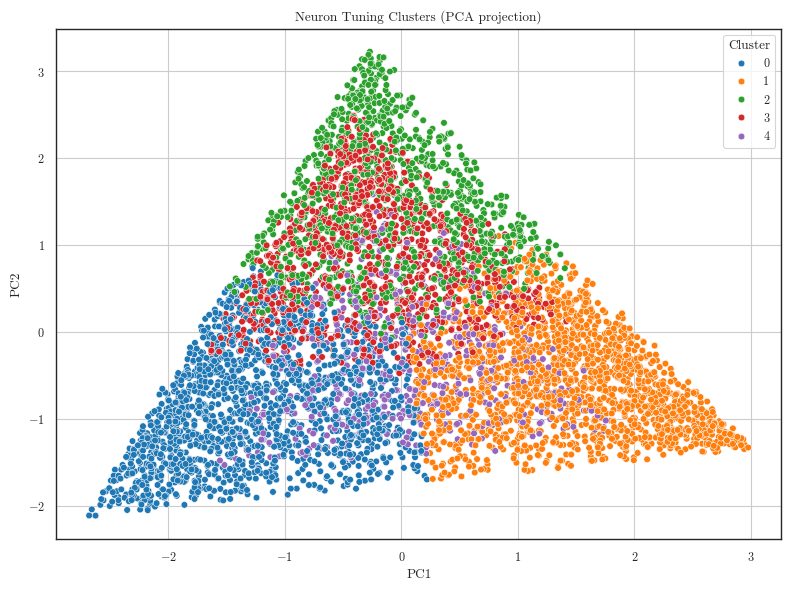

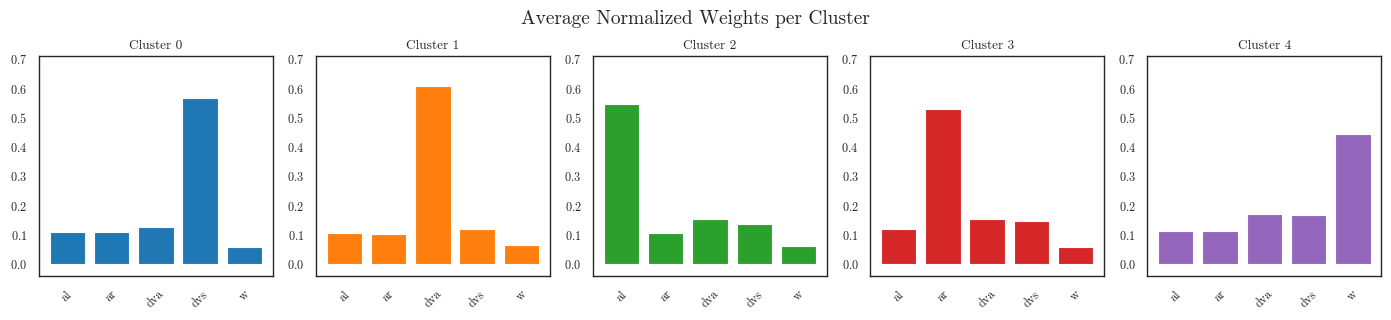

In [64]:
# --- Step 1: Build tuning matrix ---
tuning_df = monkey_weights.pivot_table(
    index=['monkey', 'session', 'neuron', 'population'],
    columns='variable',
    values='norm_weight',
    aggfunc='first'
).dropna()

tuning_matrix = tuning_df.to_numpy()
tuning_matrix_scaled = StandardScaler().fit_transform(tuning_matrix)

# --- Step 2: Automatically determine best number of clusters ---
sil_scores = []
k_range = range(2, 11)  # Try K from 2 to 10

for k in k_range:
    kmeans_k = KMeans(n_clusters=k, random_state=0, n_init='auto')
    labels_k = kmeans_k.fit_predict(tuning_matrix_scaled)
    score = silhouette_score(tuning_matrix_scaled, labels_k)
    sil_scores.append(score)

best_k = k_range[np.argmax(sil_scores)]
print(f"Best number of clusters (by silhouette): {best_k}")

# best_k = 8

# --- Step 3: Final clustering with best K ---
kmeans = KMeans(n_clusters=best_k, random_state=0, n_init='auto')
cluster_labels = kmeans.fit_predict(tuning_matrix_scaled)
tuning_df['cluster'] = cluster_labels

# --- Step 4: Dominant variable per neuron ---
# Dominant = variable with largest absolute norm_weight
abs_weights = np.abs(tuning_df.drop(columns='cluster'))
dominant_var = abs_weights.idxmax(axis=1)
tuning_df['dominant_variable'] = dominant_var

# --- Step 5: Visualize tuning space with PCA ---
pca = PCA(n_components=2)
proj_2d = pca.fit_transform(tuning_matrix_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=proj_2d[:, 0], y=proj_2d[:, 1],
                hue=tuning_df['cluster'], palette='tab10')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Neuron Tuning Clusters (PCA projection)')
plt.legend(title='Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Step 6: Visualize mean tuning vector per cluster ---
cluster_means = tuning_df.drop(columns=['cluster', 'dominant_variable']).groupby(tuning_df['cluster']).mean()

# Plot cluster-wise tuning profiles
n_clusters = cluster_means.shape[0]
variables = cluster_means.columns

plt.figure(figsize=(14, 3))
for i in range(n_clusters):
    plt.subplot(1, n_clusters, i + 1)
    plt.bar(variables, cluster_means.iloc[i], color=sns.color_palette('tab10')[i])
    plt.xticks(rotation=45)
    plt.title(f'Cluster {i}')
    plt.ylim(cluster_means.min().min() - 0.1, cluster_means.max().max() + 0.1)
    plt.tight_layout()

plt.suptitle("Average Normalized Weights per Cluster", fontsize=14, y=1.05)
plt.show()
